In [8]:
import os

formats_to_convert = [".m4a"]

if not os.path.exists("VoxCeleb_gender"):
    !pip install gdown pydub librosa
    !gdown https://drive.google.com/uc?id=1V3lNnSDv71AJYIj71V4_xD0ir0DrXxEV
    !tar -xf VoxCeleb_gender.zip #!tar -xf VoxCeleb_gender.zip
    !del VoxCeleb_gender.zip     #!del

else:
    print("Dataset already downloaded.")

^C


In [11]:
import librosa
import scipy.signal as ss
import numpy as np
import pandas as pd
import os

def extract_mfcc(file_path, n_mfcc=12, win_length=320, hop_length=160):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    if sr != 16000:
        wave = librosa.resample(wave, sr, 16000)
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc, window=ss.windows.hamming, win_length=win_length, hop_length=hop_length)
    return mfcc

# Build data in memory

In [12]:
mfcc_coeff_amount = 12

In [13]:

aux = []

for (dirpath, dirnames, filenames) in os.walk("VoxCeleb_gender"):
    for filename in filenames:
        if filename.endswith(".wav"):
            filepath = dirpath + "/" + filename
            aux.append({"file": filepath, "gender": dirpath.split("/")[-1]})

df = pd.DataFrame(aux)
            

In [14]:
df["mfcc"] = pd.Series(name="mfcc", dtype=object)
display(df)

,file,gender,mfcc
0,VoxCeleb_gender\females/0.wav,VoxCeleb_gender\females,NaN
1,VoxCeleb_gender\females/1.wav,VoxCeleb_gender\females,NaN
2,VoxCeleb_gender\females/10.wav,VoxCeleb_gender\females,NaN
3,VoxCeleb_gender\females/100.wav,VoxCeleb_gender\females,NaN
4,VoxCeleb_gender\females/1000.wav,VoxCeleb_gender\females,NaN
...,...,...,...
5988,VoxCeleb_gender\males/995.wav,VoxCeleb_gender\males,NaN
5989,VoxCeleb_gender\males/996.wav,VoxCeleb_gender\males,NaN
5990,VoxCeleb_gender\males/997.wav,VoxCeleb_gender\males,NaN
5991,VoxCeleb_gender\males/998.wav,VoxCeleb_gender\males,NaN


In [15]:


for i in range(len(df)):
    mfcc_coeffs = extract_mfcc(df.loc[i, "file"], n_mfcc=mfcc_coeff_amount).ravel()
    aux_coeffs = np.zeros(len(mfcc_coeffs))
    for j in range(len(mfcc_coeffs)//mfcc_coeff_amount):
        if np.linalg.norm(mfcc_coeffs[j*mfcc_coeff_amount:(j+1)*mfcc_coeff_amount]) > 0.001:
            aux_coeffs[j*mfcc_coeff_amount:(j+1)*mfcc_coeff_amount] = mfcc_coeffs[j*mfcc_coeff_amount:(j+1)*mfcc_coeff_amount]
    
    df.at[i, "mfcc"] = aux_coeffs

In [16]:
display(df)

,file,gender,mfcc
0,VoxCeleb_gender\females/0.wav,VoxCeleb_gender\females,"[-297.642333984375, -311.516357421875, -333.22..."
1,VoxCeleb_gender\females/1.wav,VoxCeleb_gender\females,"[-237.64122009277344, -249.89483642578125, -26..."
2,VoxCeleb_gender\females/10.wav,VoxCeleb_gender\females,"[-442.0604553222656, -442.9739990234375, -473...."
3,VoxCeleb_gender\females/100.wav,VoxCeleb_gender\females,"[-217.43252563476562, -215.3289031982422, -202..."
4,VoxCeleb_gender\females/1000.wav,VoxCeleb_gender\females,"[-310.47503662109375, -292.7668762207031, -310..."
...,...,...,...
5988,VoxCeleb_gender\males/995.wav,VoxCeleb_gender\males,"[-486.3794860839844, -482.3790588378906, -486...."
5989,VoxCeleb_gender\males/996.wav,VoxCeleb_gender\males,"[-296.01495361328125, -315.9795227050781, -288..."
5990,VoxCeleb_gender\males/997.wav,VoxCeleb_gender\males,"[-539.71240234375, -535.8696899414062, -522.54..."
5991,VoxCeleb_gender\males/998.wav,VoxCeleb_gender\males,"[-674.9623413085938, -657.7991333007812, -662...."


# EDA

# Model Training

In [33]:
X = df.drop(columns=["file", "gender"])
y = df["gender"]

In [45]:
X = []

13524
5532
4920
8148
5532
22044
7992
13908
18204
13368


In [61]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x000002150D28AD40>)

In [57]:
import numpy as np

n_samples = 500
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)  # general
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])  # spherical

X = np.concatenate([component_1, component_2])

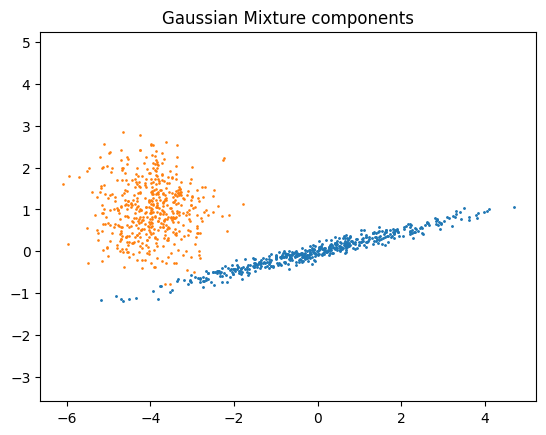

In [58]:
import matplotlib.pyplot as plt

plt.scatter(component_1[:, 0], component_1[:, 1], s=1.1)
plt.scatter(component_2[:, 0], component_2[:, 1], s=0.8)
plt.title("Gaussian Mixture components")
plt.axis("equal")
plt.show()

In [59]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x000002150D106950>)

In [60]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
19,2,full,1046.793662
20,3,full,1083.652535
21,4,full,1114.835102
22,5,full,1151.243322
23,6,full,1181.713463
